# 【第1回_Beginner限定コンペ】銀行の顧客ターゲティング

顧客の属性情報などから定期預金キャンペーンの反応率を予測しよう。

https://signate.jp/competitions/292

XGBoost編

## ライブラリインポート

In [687]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import lightgbm as lgb
#from optuna.integration import lightgbm as lgb
import xgboost as xgb
#import featuretools as ft

#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

## データ読み込み・前処理

In [688]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submit_df = pd.read_csv('submit_sample.csv', header=None)

In [689]:
print(train_df.shape)
print(test_df.shape)

(27100, 18)
(18050, 17)


In [690]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27100 non-null  int64 
 1   age        27100 non-null  int64 
 2   job        27100 non-null  object
 3   marital    27100 non-null  object
 4   education  27100 non-null  object
 5   default    27100 non-null  object
 6   balance    27100 non-null  int64 
 7   housing    27100 non-null  object
 8   loan       27100 non-null  object
 9   contact    27100 non-null  object
 10  day        27100 non-null  int64 
 11  month      27100 non-null  object
 12  duration   27100 non-null  int64 
 13  campaign   27100 non-null  int64 
 14  pdays      27100 non-null  int64 
 15  previous   27100 non-null  int64 
 16  poutcome   27100 non-null  object
 17  y          27100 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [691]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


In [692]:
test_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,35,technician,single,secondary,no,89043,no,no,cellular,7,feb,101,2,184,2,success
1,1,37,services,married,secondary,no,64372,yes,no,cellular,7,jul,158,3,241,0,unknown
2,2,31,services,single,secondary,no,31606,yes,no,unknown,15,may,152,2,47,0,unknown
3,3,31,admin.,married,secondary,no,94826,yes,no,cellular,27,may,345,2,490,0,unknown
4,4,32,services,married,secondary,no,100401,no,no,cellular,7,jan,126,1,686,0,other


In [693]:
# job のラベリングを y の平均の低い順にしてみる
#train_df.groupby('job').mean().sort_values('y')

データメモ

- testデータの `job` に `unknown` が一人いる (trainデータにはいない)

In [694]:
# one hot encoding
train_df = pd.get_dummies(train_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
test_df = pd.get_dummies(test_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
test_df.drop(['job_unknown'], axis=1, inplace=True)

df_list = [train_df, test_df]

#job_encoder = LabelEncoder()
#job_encoder.fit(test_df['job'])

for df in df_list:
    #df['job'] = job_encoder.transform(df['job'])
    #df['job'] = df['job'].map({'unknown': 1, 'technician': 2, 'blue-collar': 3, 'services': 4, 'entrepreneur': 5, 'admin.': 6, 'management': 7, 'housemaid': 8, 'self-employed': 9, 'unemployed': 10, 'retired': 11, 'student': 12})

    #df['marital'] = df['marital'].map({'married': 2, 'divorced':1, 'single': 0})
    #df.drop(['marital'], axis=1, inplace=True)

    #df['education'] = df['education'].map({'tertiary': 3, 'secondary': 2, 'primary': 1, 'unknown': 0})
    #df.drop(['education'], axis=1, inplace=True)

    #df['default'] = df['default'].map({'yes': 1, 'no': 0})
    df.drop(['default'], axis=1, inplace=True)

    df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
    #df.drop(['housing'], axis=1, inplace=True)
    
    df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
    #df.drop(['loan'], axis=1, inplace=True)

    #df['contact'] = df['contact'].map({'telephone': 2, 'cellular': 1, 'unknown': 0})
    #df.drop(['contact'], axis=1, inplace=True)

    #df['poutcome'] = df['poutcome'].map({'success': 3, 'unknown': 2, 'failure': 1, 'other': 1})
    
    df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
    #df.drop(['day', 'month'], axis=1, inplace=True)
    
    # Feb 30 とかあって、正確には変換できない
    #df['days'] = pd.to_datetime('2016/' + df['month'].astype(str).str.pad(2,fillchar='0') + '/' + df['day'].astype(str).str.pad(2,fillchar='0'), format='%Y/%m/%d').dt.strftime('%j')
    df['days'] = df['month'] * 31 + df['day']
    
    # featuretools で良さそうだったので。。
    #df['dpo'] = df['days'] / df['poutcome']
    
    df.drop(['id'], axis=1, inplace=True)
    
# featuretools用
#y = train_df.pop('y')
#train_df['train'] = 1
#test_df['train'] = 0
#test_df['id'] = test_df['id'] + len(train_df)

In [695]:
train_df.head()

,age,balance,housing,loan,day,month,duration,campaign,pdays,previous,...,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,days
0,31,12294,1,0,21,11,101,3,498,0,...,0,0,1,0,0,0,1,0,0,362
1,29,43027,0,0,22,8,158,2,702,0,...,1,0,1,0,0,0,0,0,1,270
2,35,12252,1,0,11,11,351,1,826,0,...,1,0,1,0,0,1,0,0,0,352
3,31,99121,1,1,16,5,658,2,120,0,...,0,0,0,0,1,1,0,0,0,171
4,48,42005,1,0,3,4,177,1,273,0,...,0,0,0,1,0,0,0,0,1,127


In [696]:
test_df.head()

,age,balance,housing,loan,day,month,duration,campaign,pdays,previous,...,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,days
0,35,89043,0,0,7,2,101,2,184,2,...,0,0,1,0,0,0,0,1,0,69
1,37,64372,1,0,7,7,158,3,241,0,...,0,0,1,0,0,0,0,0,1,224
2,31,31606,1,0,15,5,152,2,47,0,...,0,0,0,0,1,0,0,0,1,170
3,31,94826,1,0,27,5,345,2,490,0,...,0,0,1,0,0,0,0,0,1,182
4,32,100401,0,0,7,1,126,1,686,0,...,0,0,1,0,0,0,1,0,0,38


In [697]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  27100 non-null  int64
 1   balance              27100 non-null  int64
 2   housing              27100 non-null  int64
 3   loan                 27100 non-null  int64
 4   day                  27100 non-null  int64
 5   month                27100 non-null  int64
 6   duration             27100 non-null  int64
 7   campaign             27100 non-null  int64
 8   pdays                27100 non-null  int64
 9   previous             27100 non-null  int64
 10  y                    27100 non-null  int64
 11  job_admin.           27100 non-null  uint8
 12  job_blue-collar      27100 non-null  uint8
 13  job_entrepreneur     27100 non-null  uint8
 14  job_housemaid        27100 non-null  uint8
 15  job_management       27100 non-null  uint8
 16  job_retired          2

In [698]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18050 entries, 0 to 18049
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  18050 non-null  int64
 1   balance              18050 non-null  int64
 2   housing              18050 non-null  int64
 3   loan                 18050 non-null  int64
 4   day                  18050 non-null  int64
 5   month                18050 non-null  int64
 6   duration             18050 non-null  int64
 7   campaign             18050 non-null  int64
 8   pdays                18050 non-null  int64
 9   previous             18050 non-null  int64
 10  job_admin.           18050 non-null  uint8
 11  job_blue-collar      18050 non-null  uint8
 12  job_entrepreneur     18050 non-null  uint8
 13  job_housemaid        18050 non-null  uint8
 14  job_management       18050 non-null  uint8
 15  job_retired          18050 non-null  uint8
 16  job_self-employed    1

In [699]:
# featuretools による総当り特徴量生成

#df = pd.concat([train_df, test_df])

#es = ft.EntitySet(id='bank')
#es.entity_from_dataframe(entity_id='bank', dataframe=df, index='id')
#feature_matrix, feature_defs = ft.dfs(
#    entityset=es,
#    target_entity='bank',
#    trans_primitives=['subtract_numeric'],
#    agg_primitives=[],
#    max_depth=1,
#)

#df_dict = {}
#for name, group in feature_matrix.groupby('train'):
#    df_dict[name] = group
    
#train_df = df_dict[1]
#test_df = df_dict[0]

#train_df.drop(['train'], axis=1, inplace=True)
#test_df.drop(['train'], axis=1, inplace=True)


In [700]:
#train_df.head()

In [701]:
#test_df.head()

In [702]:
#train_df.info()

In [703]:
#train_pg = sns.pairplot(train_df.drop(['month', 'day'], axis=1), hue='y')
#train_pg.savefig('train_df.png')

## 学習準備

In [704]:
y = train_df.pop('y')

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=42)

train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)
final_train_set = xgb.DMatrix(train_df, label=y)

## ハイパーパラメータ

In [705]:
xgb_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    # 以下はoptunaでチューニングする
    #'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    #'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    #'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    #'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    #'drop_rate': 0.15
}

## 学習

In [706]:
evaluation_results = {}

clf = xgb.train(
    xgb_params,
    train_data,
    1000
    train_set=train_data,
    params=lgb_params,
    valid_sets=[train_data, test_data], 
    valid_names=['Train', 'Test'],
    evals_result=evaluation_results,
    num_boost_round=1000,
    verbose_eval=0
)
optimum_boost_rounds = clf.best_iteration

print('Result:')
print(clf.params)
print(clf.best_score)


feature_fraction, val_score: 0.199262:  14%|#4        | 1/7 [00:05<00:33,  5.51s/it][I 2020-08-07 01:52:09,696] Trial 0 finished with value: 0.19926164596248927 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.19926164596248927.

feature_fraction, val_score: 0.199262:  29%|##8       | 2/7 [00:10<00:27,  5.50s/it][I 2020-08-07 01:52:15,182] Trial 1 finished with value: 0.2009083544990775 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.19926164596248927.

feature_fraction, val_score: 0.199249:  43%|####2     | 3/7 [00:16<00:21,  5.49s/it][I 2020-08-07 01:52:20,651] Trial 2 finished with value: 0.19924938082837812 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.19924938082837812.

feature_fraction, val_score: 0.199062:  57%|#####7    | 4/7 [00:21<00:16,  5.49s/it][I 2020-08-07 01:52:26,120] Trial 3 finished with value: 0.19906227785075503 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 0.1990

Result:
{'boosting': 'dart', 'application': 'binary', 'metric': 'binary_logloss', 'lambda_l1': 1.3533996559764315e-07, 'lambda_l2': 3.6733167852318715e-07, 'num_leaves': 11, 'feature_fraction': 0.6, 'bagging_fraction': 0.7161944272864066, 'bagging_freq': 7, 'min_child_samples': 20}
defaultdict(<class 'collections.OrderedDict'>, {'Train': OrderedDict([('binary_logloss', 0.15243784373404404)]), 'Test': OrderedDict([('binary_logloss', 0.192384981677009)])})


## 可視化

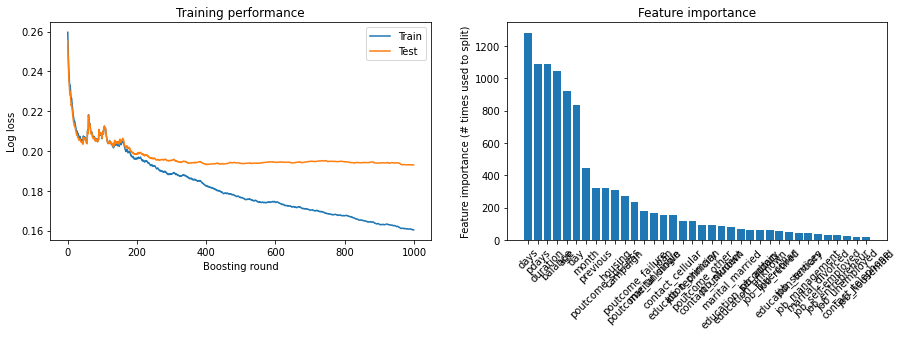

In [707]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': clf.feature_name(), 
                            'importance': clf.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'], rotation = 45)
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [708]:
importances.sort_values('importance')

,features,importance
13,job_housemaid,16
29,contact_telephone,20
20,job_unemployed,24
12,job_entrepreneur,28
16,job_self-employed,30
21,marital_divorced,37
14,job_management,40
17,job_services,43
26,education_tertiary,46
15,job_retired,58


In [709]:
preds = np.round(clf.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

Accuracy score = 	 0.9365313653136531
Precision score = 	 0.7868852459016393
Recall score =   	 0.2318840579710145
F1 score =      	 0.35820895522388063


## 推論

In [710]:
test_pred = clf.predict(test_df, num_iteration=optimum_boost_rounds)

In [711]:
submit_df[1] = test_pred
submit_df.to_csv('submit.csv', header=False, index=False)